In [2]:
# Name: Jayant Malani
# Email: jmalani@eng.ucsd.edu
# PID: A53102766

from pyspark.mllib.linalg import Vectors
from pyspark.mllib.regression import LabeledPoint

from string import split,strip

from pyspark.mllib.tree import GradientBoostedTrees, GradientBoostedTreesModel
from pyspark.mllib.tree import RandomForest, RandomForestModel

from pyspark.mllib.util import MLUtils

### Higgs data set
* **URL:** http://archive.ics.uci.edu/ml/datasets/HIGGS#  
* **Abstract:** This is a classification problem to distinguish between a signal process which produces Higgs bosons and a background process which does not.

**Data Set Information:**  
The data has been produced using Monte Carlo simulations. The first 21 features (columns 2-22) are kinematic properties measured by the particle detectors in the accelerator. The last seven features are functions of the first 21 features; these are high-level features derived by physicists to help discriminate between the two classes. There is an interest in using deep learning methods to obviate the need for physicists to manually develop such features. Benchmark results using Bayesian Decision Trees from a standard physics package and 5-layer neural networks are presented in the original paper. The last 500,000 examples are used as a test set.



In [3]:
#define feature names
feature_text='lepton pT, lepton eta, lepton phi, missing energy magnitude, missing energy phi, jet 1 pt, jet 1 eta, jet 1 phi, jet 1 b-tag, jet 2 pt, jet 2 eta, jet 2 phi, jet 2 b-tag, jet 3 pt, jet 3 eta, jet 3 phi, jet 3 b-tag, jet 4 pt, jet 4 eta, jet 4 phi, jet 4 b-tag, m_jj, m_jjj, m_lv, m_jlv, m_bb, m_wbb, m_wwbb'
features=[strip(a) for a in split(feature_text,',')]
print len(features),features

28 ['lepton pT', 'lepton eta', 'lepton phi', 'missing energy magnitude', 'missing energy phi', 'jet 1 pt', 'jet 1 eta', 'jet 1 phi', 'jet 1 b-tag', 'jet 2 pt', 'jet 2 eta', 'jet 2 phi', 'jet 2 b-tag', 'jet 3 pt', 'jet 3 eta', 'jet 3 phi', 'jet 3 b-tag', 'jet 4 pt', 'jet 4 eta', 'jet 4 phi', 'jet 4 b-tag', 'm_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb']


In [4]:
# create a directory called higgs, download and decompress HIGGS.csv.gz into it

from os.path import exists
if not exists('higgs'):
    print "creating directory higgs"
    !mkdir higgs
%cd higgs
if not exists('HIGGS.csv'):
    if not exists('HIGGS.csv.gz'):
        print 'downloading HIGGS.csv.gz'
        !curl -O http://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz
    print 'decompressing HIGGS.csv.gz --- May take 5-10 minutes'
    !gunzip -f HIGGS.csv.gz
!ls -l
%cd ..

/home/jayantmalani/spark-1.6.0-bin-hadoop2.6/cse255/UCSD_BigData_2016/Homeworks/HW-5/higgs
total 7847172K
-rw-rw-r-- 1 jayantmalani jayantmalani 8035497980 May 15 12:32 HIGGS.csv
/home/jayantmalani/spark-1.6.0-bin-hadoop2.6/cse255/UCSD_BigData_2016/Homeworks/HW-5


### As done in previous notebook, create RDDs from raw data and build Gradient boosting and Random forests models. Consider doing 1% sampling since the dataset is too big for your local machine

In [5]:
!head -2 higgs/HIGGS.csv

1.000000000000000000e+00,8.692932128906250000e-01,-6.350818276405334473e-01,2.256902605295181274e-01,3.274700641632080078e-01,-6.899932026863098145e-01,7.542022466659545898e-01,-2.485731393098831177e-01,-1.092063903808593750e+00,0.000000000000000000e+00,1.374992132186889648e+00,-6.536741852760314941e-01,9.303491115570068359e-01,1.107436060905456543e+00,1.138904333114624023e+00,-1.578198313713073730e+00,-1.046985387802124023e+00,0.000000000000000000e+00,6.579295396804809570e-01,-1.045456994324922562e-02,-4.576716944575309753e-02,3.101961374282836914e+00,1.353760004043579102e+00,9.795631170272827148e-01,9.780761599540710449e-01,9.200048446655273438e-01,7.216574549674987793e-01,9.887509346008300781e-01,8.766783475875854492e-01
1.000000000000000000e+00,9.075421094894409180e-01,3.291472792625427246e-01,3.594118654727935791e-01,1.497969865798950195e+00,-3.130095303058624268e-01,1.095530629158020020e+00,-5.575249195098876953e-01,-1.588229775428771973e+00,2.173076152801513672e+00,8.12581181526

In [6]:
path='higgs/HIGGS.csv'
inputRDD=sc.textFile(path)
inputRDD.first()

u'1.000000000000000000e+00,8.692932128906250000e-01,-6.350818276405334473e-01,2.256902605295181274e-01,3.274700641632080078e-01,-6.899932026863098145e-01,7.542022466659545898e-01,-2.485731393098831177e-01,-1.092063903808593750e+00,0.000000000000000000e+00,1.374992132186889648e+00,-6.536741852760314941e-01,9.303491115570068359e-01,1.107436060905456543e+00,1.138904333114624023e+00,-1.578198313713073730e+00,-1.046985387802124023e+00,0.000000000000000000e+00,6.579295396804809570e-01,-1.045456994324922562e-02,-4.576716944575309753e-02,3.101961374282836914e+00,1.353760004043579102e+00,9.795631170272827148e-01,9.780761599540710449e-01,9.200048446655273438e-01,7.216574549674987793e-01,9.887509346008300781e-01,8.766783475875854492e-01'

In [7]:
# Transform the text RDD into an RDD of LabeledPoints
Data=inputRDD.sample(False,0.01).cache()\
     .map(lambda line: [float(strip(x)) for x in line.split(',')])\
     .map(lambda x : LabeledPoint(x[0],x[1:])).cache()
     
Data.first()

LabeledPoint(1.0, [0.616923630238,1.43070602417,-1.11939895153,0.797622263432,-0.421214550734,1.16606831551,0.249512508512,-0.174569919705,2.1730761528,1.34704148769,0.837384343147,1.5123654604,0.0,0.416046947241,1.29545676708,1.73678183556,0.0,0.500201702118,0.889827311039,-0.446968317032,0.0,0.800571262836,0.699533641338,0.992791354656,0.811799049377,1.09089910984,1.01867890358,0.885324537754])

In [8]:
# count the number of examples of each type
total=Data.count()
print 'total data size=',total
counts=(Data.map(lambda x : (x.label,1)).countByKey()).items()  ## Fillin ##
print '              type (label):   percent of total'
print '---------------------------------------------------------'
print '\n'.join(['(%3.1f):\t%4.2f'%(a[0],100.0*a[1]/float(total)) for a in counts])

total data size= 110135
              type (label):   percent of total
---------------------------------------------------------
(0.0):	47.03
(1.0):	52.97


In [9]:
(trainingData,testData)=Data.randomSplit([0.7,0.3])
print 'Sizes: Data1=%d, trainingData=%d, testData=%d'%(Data.count(),trainingData.cache().count(),testData.cache().count())

Sizes: Data1=110135, trainingData=76934, testData=33201


In [10]:
## Gradient Boosted Trees ##
from time import time
errors={}
for depth in [1,3,6,10]:
    start=time()
    model=GradientBoostedTrees.trainClassifier(trainingData, {},maxDepth=depth, numIterations=10)##FILLIN to generate 10 trees ##)
    #print model.toDebugString()
    errors[depth]={}
    dataSets={'train':trainingData,'test':testData}
    for name in dataSets.keys():  # Calculate errors on train and test sets
        data=dataSets[name]
        Predicted=model.predict(data.map(lambda x: x.features))
        LabelsAndPredictions=data.map(lambda lp: lp.label).zip(Predicted) ### FILLIN ###
        Err = LabelsAndPredictions.filter(lambda (v,p):v != p).count()/float(data.count())
        errors[depth][name]=Err
    print depth,errors[depth],int(time()-start),'seconds'
print errors

1 {'test': 0.38375350140056025, 'train': 0.380416980788728} 141 seconds
3 {'test': 0.3306526911840005, 'train': 0.3231341149556763} 165 seconds
6 {'test': 0.3046896177825969, 'train': 0.2902097902097902} 314 seconds
10 {'test': 0.30553296587452183, 'train': 0.1992877011464372} 1481 seconds
{1: {'test': 0.38375350140056025, 'train': 0.380416980788728}, 10: {'test': 0.30553296587452183, 'train': 0.1992877011464372}, 3: {'test': 0.3306526911840005, 'train': 0.3231341149556763}, 6: {'test': 0.3046896177825969, 'train': 0.2902097902097902}}


In [11]:
B10 = errors

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


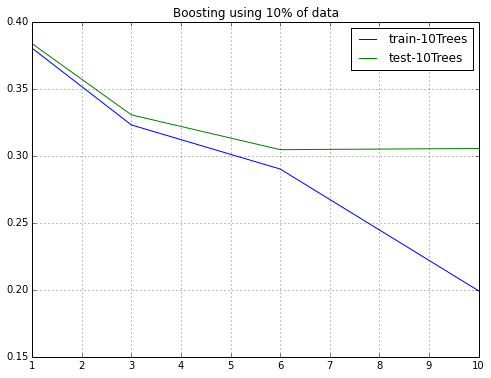

In [12]:
# Plot Train/test accuracy vs Depth of trees graph
%pylab inline
from plot_utils import *
make_figure([B10],['10Trees'],Title='Boosting using 10% of data')

In [13]:
from time import time
errors={}
for depth in [1,3,6,10,15,20]:
    start=time()
    model = RandomForest.trainClassifier(trainingData, numClasses=2, categoricalFeaturesInfo={},
                                     numTrees=10, featureSubsetStrategy="auto",
                                     impurity='gini', maxDepth=depth, maxBins=32)## FILLIN ##)
    #print model.toDebugString()
    errors[depth]={}
    dataSets={'train':trainingData,'test':testData}
    for name in dataSets.keys():  # Calculate errors on train and test sets
        data=dataSets[name]
        Predicted=model.predict(data.map(lambda x: x.features))
        LabelsAndPredictions=data.map(lambda lp: lp.label).zip(Predicted) ### FILLIN ###
        Err = LabelsAndPredictions.filter(lambda (v,p):v != p).count()/float(data.count())
        errors[depth][name]=Err
    print depth,errors[depth],int(time()-start),'seconds'
print errors

1 {'test': 0.3960724074576067, 'train': 0.39696363116437466} 64 seconds
3 {'test': 0.38453661034306197, 'train': 0.3846283827696467} 74 seconds
6 {'test': 0.3195385681154182, 'train': 0.31202069306158525} 124 seconds
10 {'test': 0.30785217312731544, 'train': 0.2659942288195076} 276 seconds
15 {'test': 0.3114062829432848, 'train': 0.1258221332570775} 1021 seconds
20 {'test': 0.31752055660974066, 'train': 0.031156575766241194} 2003 seconds
{1: {'test': 0.3960724074576067, 'train': 0.39696363116437466}, 3: {'test': 0.38453661034306197, 'train': 0.3846283827696467}, 6: {'test': 0.3195385681154182, 'train': 0.31202069306158525}, 10: {'test': 0.30785217312731544, 'train': 0.2659942288195076}, 15: {'test': 0.3114062829432848, 'train': 0.1258221332570775}, 20: {'test': 0.31752055660974066, 'train': 0.031156575766241194}}


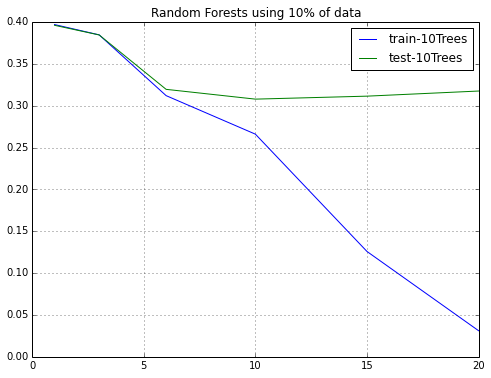

In [14]:
RF_10trees = errors
# Plot Train/test accuracy vs Depth of trees graph
make_figure([RF_10trees],['10Trees'],Title='Random Forests using 10% of data')

In [15]:
RF_10trees

{1: {'test': 0.3960724074576067, 'train': 0.39696363116437466},
 3: {'test': 0.38453661034306197, 'train': 0.3846283827696467},
 6: {'test': 0.3195385681154182, 'train': 0.31202069306158525},
 10: {'test': 0.30785217312731544, 'train': 0.2659942288195076},
 15: {'test': 0.3114062829432848, 'train': 0.1258221332570775},
 20: {'test': 0.31752055660974066, 'train': 0.031156575766241194}}

In [16]:
def make_figure2(DataSets1,DataSets2,names,Title='no title',size=(8,6)):
    figure(figsize=size)
    for i in range(len(DataSets1)):
        keys,train,test = extract_errors(DataSets1[i])
        plot(keys,train,label='GBtrain-'+names[i])
        plot(keys,test,label='GBtest-'+names[i])
    for i in range(len(DataSets2)):
        keys,train,test = extract_errors(DataSets2[i])
        plot(keys,train,label='RFtrain-'+names[i])
        plot(keys,test,label='RFtest-'+names[i])
    title(Title)
    grid()
    legend()

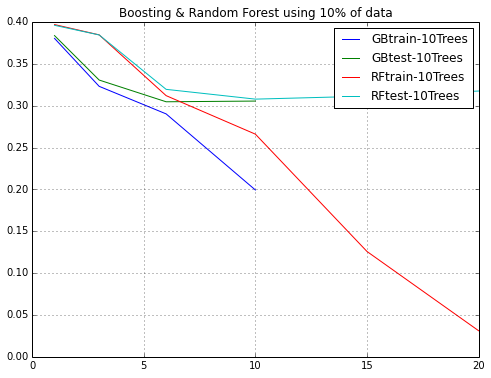

In [17]:
make_figure2([B10],[RF_10trees],['10Trees'],Title='Boosting & Random Forest using 10% of data')